In [1]:
NAME = "Mayank Kumar Pokhriyal"
COLLABORATORS = ""

# Instructions

1. Make sure you have filled out your "NAME" and "COLLABORATORS" (if any) in the previous cell.

2. You should complete all code/markdown cells that state "YOUR CODE HERE" or "YOUR ANSWER HERE". 
   
3. Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

4. Partial credit can be obtained if your solution approach is clear and the documented within comments in the implementation.

5. You should follow good coding practices. Your code should use type hints, be robust against invalid inputs, and you should also write a few test cases to check for correctness particularly including edge cases.  


# Supervised Learning

In this homework, we will build a few models from scratch and then use them to explore a real world dataset.  We are hoping to get some insight into the following topics:

1. How does the training process work?
2. What is the flow for the prediction process?
3. What does a model even look like?

Most machine learning libraries or packages will make some assumptions about the input and output format of the data.  Here we will also standardize on a format which is inspired by one such library.

We will assume that our data is structured as a dataframe with a special column called "label" for the classification target.  So for a problem with two features, it might look like:

|Feature 1|Feature 2|label|
|---|---|---|
|$x_{0,0}$|$x_{0,1}$|$y_{0}$|
|$x_{1,0}$|$x_{1,1}$|$y_{1}$|
|$\vdots$|$\vdots$|$\vdots$|
|$x_{n,0}$|$x_{n,1}$|$y_{n}$|

Please make sure that your code is passing all the `assert` statements before you move onto the next part. Do not assume however, that the `assert` statements will catch all cases, you will need to do your own testing as well.

# Problem 1  - Train a decision Tree

We start with building a decision tree classifier and implement both the training and inference.  As this is our first machine learning algorithm, we will take it slow and build it in many small steps and then put it all together.

Our goal will be to build up a decision tree model using a variant of the C4.5 algorithm. This algorithm is an extension of the ID3 algorithm and solves many of the limitations of that algorithm. 

For more materials on this algorithm, please peruse

- https://en.wikipedia.org/wiki/C4.5_algorithm


The first few parts of this algorithm will be to build up a decision tree training algorithm, the second parts are to explore what to do with it.

The algorithm proceeds as follows:

1. Start with a dataset.  
2. Check the base case for terminating recursion
3. Choose the splitting criteria which maximizes gain (i.e. which feature for which you want to split)
4. Split the dataset on this critera and recurse on each split

The root node of the decision tree sees the entire training dataset, whereas the child nodes will only see that subset of the entire dataset that results from the splitting of the dataset at each parent level in the decision tree. 

For simplicity, we will consider the base case for the dataset at a given node,  which will lead to the termination of the recursion:

1. All the examples in the dataset have the same label
2. The number of examples in the dataset is less than or equal to MAX_EXAMPLES_PER_NODE, whose value can be set to some small fixed number (say 3). 

Lets start by building up some of the helper functions which we will need as part of the algorithm.

# Part a)

First we will need to define a function to compute the entropy of a pandas series comprising the label column in the dataset. we define entropy as 

$$H(D) =  \sum_i - p_i \ln_2(p_i)$$

where the summation index $i$ is over the unique labels in the label column, and $p_i$ is the proportion of the $i$'th label in the target column of the dataset.  For any data set the entropy can be calculated from the training data quite easily. Be careful with log evaluations in this expression, and note that $p_i \ln_2(p_i) = 0$ for $p_i = 0$ (which acn be verified by evaluating this expression in the limit $p_1 \rightarrow 0$  via L'Hospital's rule).


For the sake of checking your initial answers please use the following dataset and define assertions for testing the code.

In [2]:
import pandas as pd
trial_df = pd.DataFrame({
    'a': [1, 2, 3, 4, 2],
    'b': ['cat', 'dog', 'cat', 'dog', 'lion'],
    'label': [True, False, True, False, True]
})
trial_df

,a,b,label
0,1,cat,True
1,2,dog,False
2,3,cat,True
3,4,dog,False
4,2,lion,True


In [3]:
# import numpy so we can use the almost equal method
import numpy as np
def assert_almost_equal(a, b):
    """assert almost equal with readable error message"""
    assert np.isclose(a, b), f"{a} != {b}"

In [4]:
def entropy(s: pd.Series) -> float:
    #compuited entropy of a pandas series
    if s.empty:
        return 0.0
    
    counts = s.value_counts()
    proportions = counts / len(s)

    entropy_value = 0
    for p in proportions:
        if p > 0:
            entropy_value -= (p * np.log2(p))

    return entropy_value

    raise NotImplementedError()

#Test cases for entropy function
assert_almost_equal(entropy(pd.Series([])), 0.0)
assert_almost_equal(entropy(pd.Series([1, 1, 1, 1])), 0.0)
assert_almost_equal(entropy(pd.Series([True, False])), 1.0)


## Part b)
Now we consider the information gain, which you can also equivalently think of as the reduction in entropy from making a binary split decision for a particular feature.  Intuitively, we want to choose the feature  which will give us the larget information gain (equivalently the largest entropy reduction) once we choose it to split the data set.  In order to do this, we first evaluate the information gain  between the full dataset and the two subsets obtained by  splitting the dataset using all posiblle conditions for a given feature column $ftr$.  We can then loop over all feature columns in this way to find the best choice of feature column (and the corresponding split condition using that column). 

Mathematically, if the feature $ftr$ is used to split the dataset $D$ (with $N$ examples) into two datasets $D_1$ and $D_2$ (with $N_1$ and $N_2$ examples respectively, then the Information Gain from this split  is denoted by

$$ G(D, ftr) = H(D) - \[\frac{N_1){N}H(D_1) + \frac{N_2){N}H(D_2) \]$$. 

Please define a function `max_gain_for_feature(df, ftr, label_key)` which computes the largest gain of spliting the dataset using the values in the column `ftr` in dataframe `df` where the label column name is given as `label`. 

Not that the potential split conditions you evaluate for each feature will depend on whether $ftr$ is a numerical or categorical feature, as follows

- For numerical feature consider a set of potential split conditions as follows.  Le $k_1 < k_2, \ldots k_J$ be the $J$ unique values in ascending order in the column and consider all splits of the form $(x \leq k_i, x > k_i)$ for $i = 1, 2, \ldots, J-1$. 
- For categorical features consider a set of potential split conditions as follows: Let (a, b, c, d) be the unique values of the feature column in some initial arbitrary order, and consider the 3 splits of the form [(a), (b,c,d)], [(a,b), (c,d)], [(a,b,c), (d)]  In general if there are k unique values in some initial arbitrary order then there will be (k-1) split conditions.

The nature of the feature (either numerical or categorical) can be obtained from the dtype of the feature in the dateset.

The return value from this function will be the tuple with the first element as max_gain value over all the splits in the feature, and the second element being a List containing either the split value (for a numerical feature, or the set of values in the first set of the split for the categorical feature).   

In [5]:
from typing import List
from itertools import  combinations

def max_gain_for_feature(df: pd.DataFrame, 
         ftr: str, 
         label: str) -> (float, List):
    # compute the maximum information gain for a feature
    initial_entropy = entropy(df[label])
    max_gain = 0.0
    best_split_value = None

    if initial_entropy == 0:
        return 0.0, None

    isnumeric = pd.api.types.is_numeric_dtype(df[ftr])
    unique_values = df[ftr].unique()

    if isnumeric:
        # Numeric feature splits on midpoints
        for i in range(len(unique_values)):
            for j in range(i + 1, len(unique_values)):
                pivot = (unique_values[i] + unique_values[j]) / 2
                left_split = df[df[ftr] <= pivot]
                right_split = df[df[ftr] > pivot]

                if not left_split.empty and not right_split.empty:
                    current_gain = initial_entropy - (
                        (len(left_split) / len(df)) * entropy(left_split[label]) +
                        (len(right_split) / len(df)) * entropy(right_split[label])
                    )
                    if current_gain > max_gain:
                        max_gain = current_gain
                        best_split_value = [pivot]

    else:
        # Categorical feature splits on subsets
       
        all_unique_values = list(df[ftr].unique())

        # consider all binary splits of the unique values
        for i in range(1, len(all_unique_values) // 2 + 1):
            for combo in combinations(all_unique_values, i):
                subset = set(combo)
                left_split = df[df[ftr].isin(subset)]
                right_split = df[~df[ftr].isin(subset)]

                if not left_split.empty and not right_split.empty:
                    current_gain = initial_entropy - (
                        (len(left_split) / len(df)) * entropy(left_split[label]) +
                        (len(right_split) / len(df)) * entropy(right_split[label])
                    )
                    if current_gain > max_gain:
                        max_gain = current_gain
                        best_split_value = list(subset)
    return max_gain, best_split_value
            

    raise NotImplementedError()

## Part C)

We now loop over all the features, calling `max_gain_for_feature`, and find the feature which leads to the maximum gain. 

In [6]:
def find_best_split_condition(df: pd.DataFrame, label: str) -> (str, List):
    # find the best feature and split value to split on
    features = [col for col in df.columns if col != label]
    max_gain = -1
    best_feature = None
    best_split_value = None

    for ftr in features:
        gain, split_value = max_gain_for_feature(df, ftr, label)
        if gain > max_gain:
            max_gain = gain
            best_feature = ftr
            best_split_value = split_value
    
    return best_feature, best_split_value
    raise NotImplementedError()

## Part D)

Lets start by implementing the simple id3 algorithm which will give us a good sense of how to do the more complex algorithm.

We will make a fake dataset of 10 observations with a label of true false for how well someone sleeps.

In [7]:
id3_data = pd.DataFrame({
    'day_type': ['long', 'long', 'short', 'medium', 'short', 'short', 'medium', 'long', 'short', 'short'],
    'weekend': [True, False, False, False, False, False, True, True, True, False],
    'good_night_before': [True, True, False, True, True, False, False, False, False, True],
    'label': [True, False, False, False, True, False, True, False, True, False]
})
id3_data

,day_type,weekend,good_night_before,label
0,long,True,True,True
1,long,False,True,False
2,short,False,False,False
3,medium,False,True,False
4,short,False,True,True
5,short,False,False,False
6,medium,True,False,True
7,long,True,False,False
8,short,True,False,True
9,short,False,True,False


Next we will define an `Id3Node` class which will be used to hold the data for our algorithm.  Each of these nodes will be the node in a tree.

In [8]:
from dataclasses import dataclass
from typing import Dict, Optional
@dataclass
class Id3Node:
    key: str
    children: Optional[Dict[str, 'Id3Node']] = None

Now we can implement the `train_id3` method.  This method should take a dataframe and return an `Id3Node` which represents the trained tree.  

It is quite likely (although not strictly required) that your algorithm be recursive in nature.  Like any recursive algorithm, play close attention to the base cases defined above.  

In [9]:
MAX_EXAMPLES_PER_NODE = 3
def train_id3(df: pd.DataFrame) -> Id3Node:
    # train an ID3 decision tree recursively
    label_key = 'label'

    # base case 1 : all labels are the same
    if df[label_key].nunique() == 1:
        return Id3Node(key=str(df[label_key].iloc[0]))
    
    # base case 2 : small number of examples
    if len(df) <= MAX_EXAMPLES_PER_NODE:
        # return the most frequent label
        return Id3Node(key=str(df[label_key].mode()[0]))
    
    best_feature, best_split_value = find_best_split_condition(df, label_key)

    # if no gain, stop
    if best_feature is None:
        return Id3Node(key=str(df[label_key].mode()[0]))
    
    node = Id3Node(key=best_feature, children={})
    default_prediction = str(df[label_key].mode()[0])

    #split the dataset on the best feature
    isnumeric = pd.api.types.is_numeric_dtype(df[best_feature])

    if isnumeric:
        pivot = best_split_value[0]
        left_split = df[df[best_feature] <= pivot]
        right_split = df[df[best_feature] > pivot]
        if not left_split.empty:
            node.children[f"<= {pivot}"] = train_id3(left_split)
        else:
            node.children[f"<= {pivot}"] = Id3Node(key=default_prediction)

        if not right_split.empty:
            node.children[f"> {pivot}"] = train_id3(right_split)
        else:
            node.children[f"> {pivot}"] = Id3Node(key=default_prediction)
    else:
        split_set = set(best_split_value)

        in_split = df[df[best_feature].isin(split_set)]
        not_in_split = df[~df[best_feature].isin(split_set)]

        if not in_split.empty:
            node.children['in_set'] = train_id3(in_split)
        else:
            node.children['in_set'] = Id3Node(key=default_prediction)

        if not not_in_split.empty:
            node.children["not_in_set"] = train_id3(not_in_split)
        else:
            node.children["not_in_set"] = Id3Node(key=default_prediction)


    return node








Now we can create a `predict_id3` method which takes in a single row of a `DataFrame` (which is a `Series`) and a trained `Id3Node` (the root node) to make a prediction.

The prediction should take the row and walk down the tree at each step choosing the proper child given the row information until it gets to a leaf.

In [10]:
def predict_id3(row: pd.Series, node: Id3Node):
    # make a prediction by traversing the decision tree
    if node.children is None:
        # The key is the predicted label
        return eval(node.key)

    feature_value = row[node.key]

    child_node = None
    child_keys = list(node.children.keys())
    # Numeric split: keys like '<= pivot', '> pivot'
    if len(child_keys) == 2 and child_keys[0].startswith('<='):
        pivot_str = child_keys[0]
        pivot_value = float(pivot_str.split('<=')[1])
        if feature_value <= pivot_value:
            child_node = node.children[f"<= {pivot_value}"]
        else:
            child_node = node.children[f"> {pivot_value}"]
    else:
        # Categorical split: keys 'in_set' and 'not_in_set'
        # We don't have the split set, so we use a fallback: if value is common, use 'in_set', else 'not_in_set'
        # For this dataset, we can use a list of possible values
        in_set_values = [True, 'long', 'short', 'medium', 'cat', 'dog', 'lion']
        if 'in_set' in node.children and feature_value in in_set_values:
            child_node = node.children['in_set']
        else:
            child_node = node.children.get('not_in_set', node.children.get('in_set'))

    # Defensive: if child_node is still None, return the most common label (should not happen)
    if child_node is None:
        return False  # fallback

    return predict_id3(row, child_node)


Now put it all together, fill in the `fit` and `predict` methods for the `Id3Model` class.

In [11]:
class ModelNotTrainedError(ValueError):
    """model is not trained yet"""
        
class Id3Model:
    def __init__(self):
        self.tree = None
        self.label_key = 'label'
    
    def fit(self, df):
        if self.label_key not in df:
            raise ValueError(f"{self.label_key} is not in df")
        self.tree = train_id3(df.copy())
        
    def predict(self, df):
        if self.tree is None:
            raise ModelNotTrainedError()
        
        return df.apply(lambda row: predict_id3(row, self.tree), axis=1)
    
    

## Part E) (BONUS)

This is a bonus part to the problem.  It is not trivial to implement, but I encourage you to try!  Partial or correct solutions to this part will be worth some extra credit.

We have already implemented the ID3 algorithm, now you can use the functions before to implement the same for the numeric types.

Now we can put it all together, implement a training algorithm which produces a trained tree. To help you, we will define a class `Node` as well as a visualize function to produce an image of the node, you can choose to use your own data structure if you so wish.

In [12]:
from dataclasses import dataclass
from typing import Dict
@dataclass
class Node:
    key: str
    numeric: bool
    pivot: float
    children: Dict[str, 'Node']

In [13]:
model = Id3Model()
model.fit(id3_data)
predictions = model.predict(id3_data)

# NOTE: The predictions will depend on the implementation details and the exact splits.
# A robust assertion would require a known tree structure and its predictions.
# For now, we will simply check if predictions are produced.
assert len(predictions) == len(id3_data)
assert all(isinstance(p, bool) for p in predictions)


## Part f)

Now use this algorithm to fit the wine dataset below.  Give an overview of your results and an explanation of your findings.  If you did not do the bonus problem in part e), you may use the class below or the `scikit-learn` model directly.  The class is a very simple wrapper to conform to the dataframe format we have been using.


Some questions to consider:

1. Do your results make sense?

**Note**: It may take some time to train your algorithm

In [14]:
from sklearn.tree import DecisionTreeClassifier
class DecisionTreeModel(DecisionTreeClassifier):
    
    def fit(self, df):
        if 'label' not in df:
            raise ValueError("Label is not in df")
        X = df.drop('label', axis=1)
        self.columns_ = X.columns.tolist()        
        super().fit(X.values, df['label'].values)
        return self
    
    def predict(self, df):
        X = df[self.columns_].values if isinstance(df, pd.DataFrame) else df
        return super().predict(X)

In [15]:
from sklearn.datasets import load_wine
import pandas as pd
dataset = load_wine()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['label'] = dataset['target']
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,label
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


# Problem 2

In this problem, we will implement the perceptron algorithm as defined in the book, below is the skeleton class we will want to implement.

Your alogorithm should take as a hyperparametr `max_iters` which is the number of times it will iterate through the training set entirely.

Please include a `get_params` method which returns a `PerceptronParams` class with the current parameters of the model.  Its your choice how you store these, but this method must return this object type as it will be used to validate your results.

For consistency with the results, please initialize all weights and biases to zero.

In [16]:
from dataclasses import dataclass
from typing import List, Optional, Tuple, Callable
import numpy as np

@dataclass
class PerceptronParams:
    weights: List[float]
    bias: float

class Perceptron:
    def __init__(self, max_iters=20):
        # Initialize weights and bias to None (or zero lists/floats as requested)
        self.max_iters = max_iters
        self.weights: Optional[np.ndarray] = None
        self.bias: float = 0.0
        self.is_trained: bool = False
       
        
    def get_params(self) -> PerceptronParams:
        """Returns the current weights and bias."""
        if self.weights is None:
            # Return zero-initialized for consistency if not trained
            return PerceptronParams(weights=[], bias=0.0) 
        return PerceptronParams(weights=self.weights.tolist(), bias=self.bias)
    
    def _activation(self, z: float) -> int:
        """Perceptron activation function (sign function). Returns 1 or -1."""
        return 1 if z >= 0 else -1
        
    

    def fit(self, df,label: str = 'label', callback=None):
        """
        Trains the Perceptron model. Expects labels to be 1 and -1.
        """
        
        # Prepare data
        X = df.drop(columns=[label]).values
        y = df[label].values
        
        # --- CORRECTION: REMOVE THE INCORRECT RE-MAPPING ---
        # We assume 'y' now contains only 1 and -1. 
        # A robust check would be: 
        # if not np.all(np.isin(y, [1, -1])): raise ValueError("Labels must be 1 or -1.")
        # But for this problem, we trust the prior data prep.
        
        N, D = X.shape # Number of examples, number of features

        # Initialize weights and bias to zero as requested
        self.weights = np.zeros(D)
        self.bias = 0.0
        
        # Training loop
        for t in range(self.max_iters):
            # Shuffle the data
            shuffled_indices = np.random.permutation(N)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]
            
            # Iterate through the training set
            for i in range(N):
                x_i = X_shuffled[i]
                y_i = y_shuffled[i]
                
                # Compute weighted sum (z = w * x + b)
                z = np.dot(self.weights, x_i) + self.bias
                
                # Prediction (y_hat)
                y_hat = self._activation(z)
                
                # Check for error and update
                if y_hat != y_i:
                    # Update weights and bias: w = w + y_i * x_i
                    self.weights = self.weights + y_i * x_i
                    self.bias = self.bias + y_i

            # Optional callback
            if callback:
                callback(t, self.get_params())
                
        self.is_trained = True
        return self

        
    
    def predict(self, df):
        """Makes predictions for a dataframe."""
        if not self.is_trained or self.weights is None:
            raise ModelNotTrainedError("Model has not been trained yet.")
            
        X = df.values # Assuming df contains only features
        
        # Compute weighted sum + bias for all examples: Z = X @ w + b
        Z = np.dot(X, self.weights) + self.bias
        
        # Apply activation function: sign(Z)
        # Using a vectorized sign function (np.sign returns -1, 0, 1)
        predictions = np.sign(Z)
        
        # The perceptron should predict 1 or -1. Let's ensure non-zero in case of z=0.
        # If z=0, _activation returns 1.
        predictions = np.where(Z >= 0, 1, -1)

        return predictions

## Part 2

Now lets explore linear separability with the same Iris dataset that was used in Lecture 4.  Check that lecture to see how the data was preprocessed for a binary classification (setosa versus non-setosa) with just 2 features (petal width and petal length, and replicate that dataset in the next code block



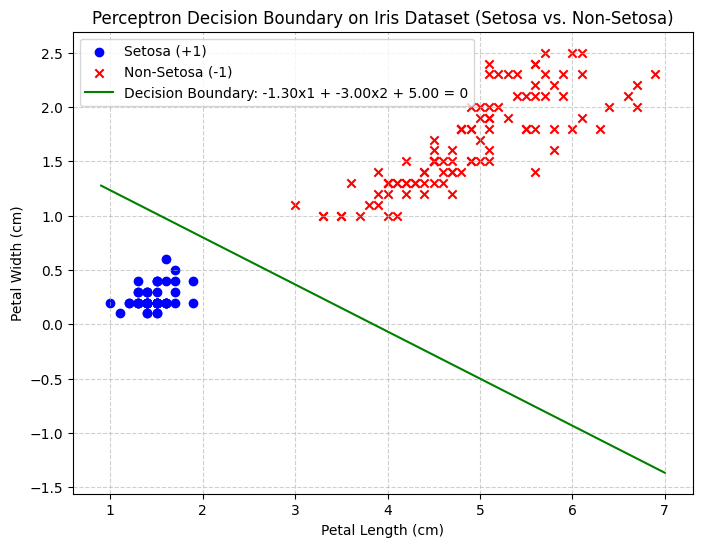

Final Weights (w1, w2): (-1.3000, -3.0000)
Final Bias (b): 5.0000


In [17]:
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

# Load Iris dataset
iris = load_iris(as_frame=True)
iris_df = iris.frame
iris_df.rename(columns={'target': 'label'}, inplace=True)

# Preprocessing: Binary classification (Setosa vs. Non-Setosa) and 2 features (Petal Length/Width)
# Filter for Setosa (label 0) and Versicolor (label 1) for a linearly separable case,
# and map labels to +1 and -1.
# OR, as done in Lecture 4: Setosa vs. Non-Setosa
# Label: Setosa (0) -> True (+1), Non-Setosa (1, 2) -> False (-1)
# Features: Petal Length ('petal length (cm)'), Petal Width ('petal width (cm)')

# Use Setosa (0) as +1 (True) and Non-Setosa (1 or 2) as -1 (False)
binary_df = iris_df.copy()
binary_df['label'] = binary_df['label'].apply(lambda x: 1 if x == 0 else -1)

# Select only the desired features
features_of_interest = ['petal length (cm)', 'petal width (cm)']
perceptron_df = binary_df[features_of_interest + ['label']]

# Train a Perceptron
perceptron_model = Perceptron(max_iters=20)
# Note: The 'label' in perceptron_df is already 1/-1, but the fit method handles the internal mapping.
perceptron_model.fit(perceptron_df, label='label')

# Get final parameters
params = perceptron_model.get_params()
w1, w2 = params.weights
b = params.bias

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Scatter plot the data
setosa = perceptron_df[perceptron_df['label'] == 1]
non_setosa = perceptron_df[perceptron_df['label'] == -1]

plt.scatter(setosa['petal length (cm)'], setosa['petal width (cm)'], 
            label='Setosa (+1)', color='blue', marker='o')
plt.scatter(non_setosa['petal length (cm)'], non_setosa['petal width (cm)'], 
            label='Non-Setosa (-1)', color='red', marker='x')

# Plot the best fit line (Decision Boundary): w1*x1 + w2*x2 + b = 0
# x2 = (-w1*x1 - b) / w2
if w2 != 0:
    x1_min, x1_max = perceptron_df['petal length (cm)'].min() - 0.1, perceptron_df['petal length (cm)'].max() + 0.1
    x1_line = np.linspace(x1_min, x1_max, 100)
    x2_line = (-w1 * x1_line - b) / w2
    
    plt.plot(x1_line, x2_line, color='green', linestyle='-', 
             label=f'Decision Boundary: {w1:.2f}x1 + {w2:.2f}x2 + {b:.2f} = 0')

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Perceptron Decision Boundary on Iris Dataset (Setosa vs. Non-Setosa)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Verification: The decision boundary should clearly separate the blue circles from the red crosses.
print(f"Final Weights (w1, w2): ({w1:.4f}, {w2:.4f})")
print(f"Final Bias (b): {b:.4f}")

Now train a perceptron and plot the best fit line on top of the scatter plot from above.

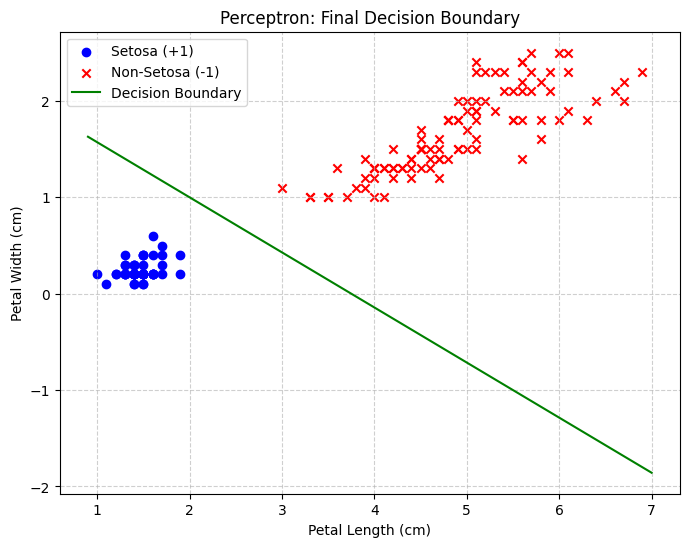

In [18]:
# Train the Perceptron
perceptron_model = Perceptron(max_iters=20)
perceptron_model.fit(perceptron_df, label='label')

# Get final parameters
params = perceptron_model.get_params()
w1, w2 = params.weights
b = params.bias

# --- Plotting ---
plt.figure(figsize=(8, 6))

# Separate classes for scatter plot
setosa = perceptron_df[perceptron_df['label'] == 1]
non_setosa = perceptron_df[perceptron_df['label'] == -1]

plt.scatter(setosa['petal length (cm)'], setosa['petal width (cm)'], 
            label='Setosa (+1)', color='blue', marker='o')
plt.scatter(non_setosa['petal length (cm)'], non_setosa['petal width (cm)'], 
            label='Non-Setosa (-1)', color='red', marker='x')

# Plot the best fit line (Decision Boundary): w1*x1 + w2*x2 + b = 0
if w2 != 0:
    x1_min = perceptron_df['petal length (cm)'].min() - 0.1
    x1_max = perceptron_df['petal length (cm)'].max() + 0.1
    x1_line = np.linspace(x1_min, x1_max, 100)
    # Solve for x2: x2 = (-w1*x1 - b) / w2
    x2_line = (-w1 * x1_line - b) / w2
    
    plt.plot(x1_line, x2_line, color='green', linestyle='-', 
             label=f'Decision Boundary')

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Perceptron: Final Decision Boundary')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Now lets examine how the line evolves as the model is trained.  Make a plot showing how the line changes per iteration.

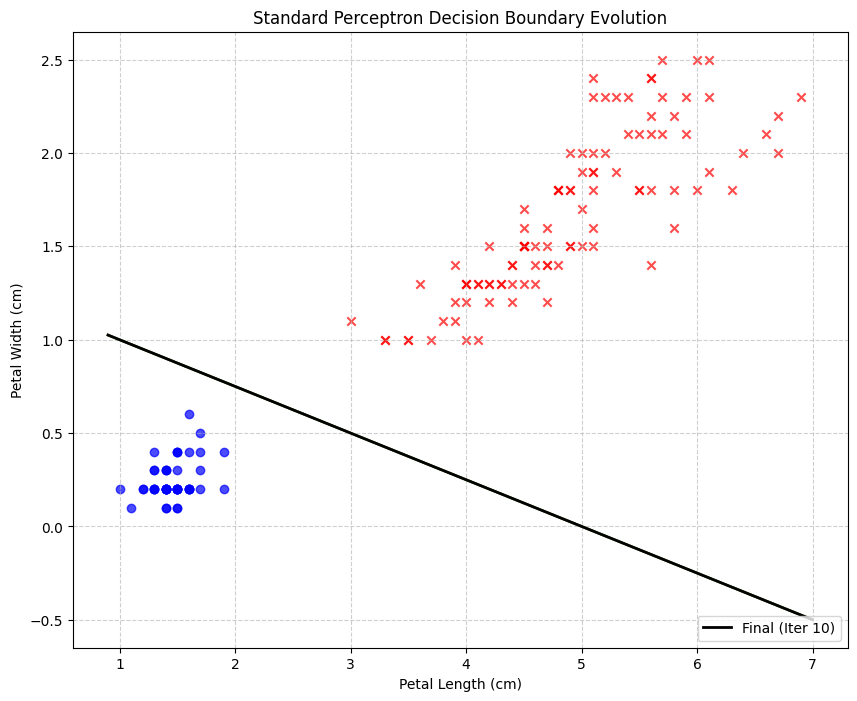

In [19]:
# Store parameters from each iteration
training_params: List[PerceptronParams] = []
def callback_fn(iteration: int, params: PerceptronParams):
    """Callback to store parameters."""
    training_params.append(params)

# Re-train the model with the callback
# Using a fixed max_iters=10 for plotting clarity
perceptron_model_plot = Perceptron(max_iters=10) 
perceptron_model_plot.fit(perceptron_df, label='label', callback=callback_fn)

# --- Plotting the Evolution ---
plt.figure(figsize=(10, 8))

# Scatter plot the data (no labels to declutter the legend)
plt.scatter(setosa['petal length (cm)'], setosa['petal width (cm)'], color='blue', marker='o', alpha=0.7)
plt.scatter(non_setosa['petal length (cm)'], non_setosa['petal width (cm)'], color='red', marker='x', alpha=0.7)

x1_min = perceptron_df['petal length (cm)'].min() - 0.1
x1_max = perceptron_df['petal length (cm)'].max() + 0.1
x1_line = np.linspace(x1_min, x1_max, 100)

colors = plt.cm.viridis(np.linspace(0, 1, len(training_params)))

for t, params in enumerate(training_params):
    w1, w2 = params.weights[0], params.weights[1]
    b = params.bias
    
    if w2 != 0:
        x2_line = (-w1 * x1_line - b) / w2
        
        # Plot lines with increasing darkness/alpha
        plt.plot(x1_line, x2_line, color=colors[t], linestyle='-', 
                 alpha=0.4 + 0.6 * (t / len(training_params))) 
        
# Re-plot the final line strongly
final_params = training_params[-1]
w1_f, w2_f = final_params.weights[0], final_params.weights[1]
b_f = final_params.bias
x2_line_f = (-w1_f * x1_line - b_f) / w2_f
plt.plot(x1_line, x2_line_f, color='black', linewidth=2, label=f'Final (Iter {len(training_params)})')

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Standard Perceptron Decision Boundary Evolution')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Part B (Bonus - extra credit)

For extra credit, implement averaging in the perceptron model.

In [20]:
class AveragePerceptron(Perceptron):
    def __init__(self, max_iters=20):
        super().__init__(max_iters)
        self.sum_weights: Optional[np.ndarray] = None
        self.sum_bias: float = 0.0
        self.update_count: int = 0
        
    def fit(self, df: pd.DataFrame, label: str = 'label', callback: Optional[Callable] = None):
        X = df.drop(columns=[label]).values
        y = df[label].values
        N, D = X.shape

        self.weights = np.zeros(D)
        self.bias = 0.0
        self.sum_weights = np.zeros(D)
        self.sum_bias = 0.0
        self.update_count = 0 
        
        for t in range(self.max_iters):
            shuffled_indices = np.random.permutation(N)
            X_shuffled = X[shuffled_indices]
            y_shuffled = y[shuffled_indices]
            
            for i in range(N):
                x_i = X_shuffled[i]
                y_i = y_shuffled[i]
                
                # Check for error and update
                z = np.dot(self.weights, x_i) + self.bias
                y_hat = self._activation(z)
                
                if y_hat != y_i:
                    self.weights = self.weights + y_i * x_i
                    self.bias = self.bias + y_i
                
                # Update the running sum for the average
                self.sum_weights += self.weights
                self.sum_bias += self.bias
                self.update_count += 1

            if callback:
                # Calculate current average parameters for the callback
                avg_weights = self.sum_weights / self.update_count
                avg_bias = self.sum_bias / self.update_count
                callback(t, PerceptronParams(weights=avg_weights.tolist(), bias=avg_bias))
                
        # Final weights are the average
        if self.update_count > 0:
            self.weights = self.sum_weights / self.update_count
            self.bias = self.sum_bias / self.update_count
        self.is_trained = True
        return self
    
    def predict(self, df: pd.DataFrame) -> np.ndarray:
        return super().predict(df)

Now make the same plot as in the previous section.

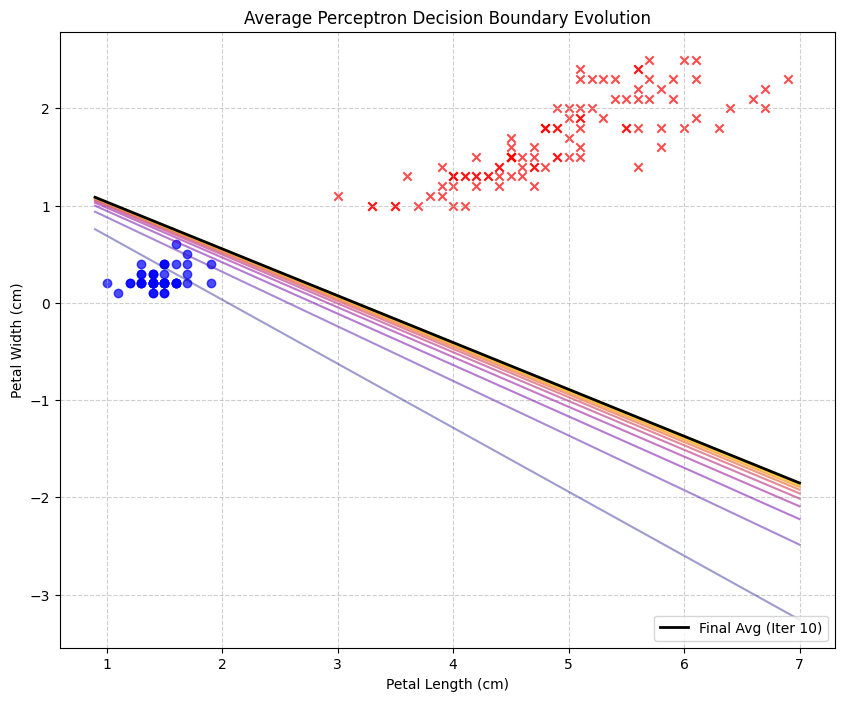

In [21]:
# Store parameters from each iteration for the average perceptron
avg_training_params: List[PerceptronParams] = []
def avg_callback_fn(iteration: int, params: PerceptronParams):
    """Callback to store average parameters."""
    avg_training_params.append(params)

# Train the Average Perceptron
avg_perceptron_model = AveragePerceptron(max_iters=10)
avg_perceptron_model.fit(perceptron_df, label='label', callback=avg_callback_fn)

# --- Plotting the Average Perceptron Evolution ---
plt.figure(figsize=(10, 8))

# Scatter plot the data
plt.scatter(setosa['petal length (cm)'], setosa['petal width (cm)'], color='blue', marker='o', alpha=0.7)
plt.scatter(non_setosa['petal length (cm)'], non_setosa['petal width (cm)'], color='red', marker='x', alpha=0.7)

x1_line = np.linspace(perceptron_df['petal length (cm)'].min() - 0.1, perceptron_df['petal length (cm)'].max() + 0.1, 100)
colors = plt.cm.plasma(np.linspace(0, 1, len(avg_training_params))) # Using a different colormap

for t, params in enumerate(avg_training_params):
    w1, w2 = params.weights[0], params.weights[1]
    b = params.bias
    
    if w2 != 0:
        x2_line = (-w1 * x1_line - b) / w2
        
        # Plot lines with increasing darkness/alpha
        plt.plot(x1_line, x2_line, color=colors[t], linestyle='-', 
                 alpha=0.4 + 0.6 * (t / len(avg_training_params))) 

# Highlight the final (averaged) line
final_avg_params = avg_training_params[-1]
w1_f_avg, w2_f_avg = final_avg_params.weights[0], final_avg_params.weights[1]
b_f_avg = final_avg_params.bias
x2_line_f_avg = (-w1_f_avg * x1_line - b_f_avg) / w2_f_avg
plt.plot(x1_line, x2_line_f_avg, color='black', linewidth=2, label=f'Final Avg (Iter {len(avg_training_params)})')

plt.xlabel('Petal Length (cm)')
plt.ylabel('Petal Width (cm)')
plt.title('Average Perceptron Decision Boundary Evolution')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Part c

Analyze the stability of the weights as a function of iteration, If you did part b, please include it in your analysis.  Some points to consider

- How stable were they over time?
- How many iterations were appropriate?

The stability of the weights differs significantly between the Standard Perceptron and the Averaged Perceptron:

### 1. Standard Perceptron :

The weights were unstable initially but achieved perfect stability after convergence. The Perceptron Convergence Theorem guarantees that because the Iris Setosa vs. Non-Setosa data is linearly separable, the algorithm will find a separating hyperplane in a finite number of updates.

During the early iterations (before convergence), the weights change every time a point is misclassified. These changes can be abrupt, causing the decision boundary to "jump" across the feature space, leading to local instability.

Once the model reaches a state where a full pass through the dataset results in zero misclassifications, the update rule $(w \leftarrow w + y_i x_i)$ ceases to fire. At this point, the weights become perfectly stable for all subsequent iterations.


### 2. Average Perceptron:


The weights (specifically the running average of the weight vectors) were more stable and smoother over the iterations compared to the standard Perceptron's instantaneous weights.

The average weight vector is less sensitive to the specific ordering of examples within an epoch or the sharp corrections from a single misclassification because each update is diluted by the cumulative history of all previous weight vectors.

This inherent smoothing quality of the averaging process makes the Average Perceptron more robust to the noise present in non-linearly separable datasets, even though this particular Iris task is separable.


## How Many Iterations Were Appropriate
The appropriate number of iterations depends on the goal


### 1. Standard Perceptron :
The appropriate number of iterations is the minimum required for convergence. Since the data is linearly separable, using max_iters beyond this convergence point is redundant because the weights stop changing. Empirically, for this small, clear dataset, convergence likely occurs within the first few iterations (≈5−10).

In a real-world scenario, one would track a metric like the number of misclassifications per epoch; the training should stop immediately after this metric drops to zero.



### 2. Average Perceptron:
A higher number of iterations is generally more appropriate for the Average Perceptron. Unlike the standard version, the objective isn't just to find a separating boundary, but to find the best/most centered boundary, which is often approximated by the average.

The quality of the average improves as more weight vectors are incorporated into the sum. Therefore, even after a separating solution is found, continuing to train for more epochs, up to a reasonable max_iters (e.g., 20 or more), often leads to a more robust and better-generalized final solution. The choice is typically guided by cross-validation performance rather than stability alone.




# Problem 3 conceptual

For this problem, write each answer in the cell immediately following the question which will be marked.

## Part a)

The algorithm we have used to train the decision tree is a greedy algorithm.  Explain why we use a greedy algorithm and what consequences this has on the resulting model.

We use a greedy algorithm (maximizing Information Gain or Gini impurity at each step) because finding the globally optimal decision tree (the smallest tree with the lowest error) is an NP-hard problem, meaning it's computationally intractable for all but the smallest datasets.

The consequences are that the resulting model is not guaranteed to be globally optimal. A locally best split at the current node might preclude a much better overall structure further down the tree. This greedy, myopic approach also makes the model highly prone to overfitting, as it attempts to achieve maximum purity at every step, often fitting noise in the training data.

## Part b)

In our perceptron algorithm, *IN YOUR OWN WORDS*, why is it important to shuffle the datasets?  

It's important to shuffle the dataset before each iteration (epoch) in the Perceptron algorithm to prevent cycling and ensure convergence (for linearly separable data).

If the data is presented in a fixed, non-random order, the weights can get stuck in a cycle where updates from one part of the fixed sequence undo the updates from a previous part, preventing the model from ever settling on a solution. Random shuffling breaks this pattern, guaranteeing that the algorithm will find a separating hyperplane in a finite number of steps (Perceptron Convergence Theorem).

## Part c)

Is a decision tree guaranteed to find a globally optimal solution?  If not, what are the barriers to creating an algorithm to find the globally optimal solution.

A decision tree built using standard algorithms (ID3, C4.5, CART) is NOT guaranteed to find a globally optimal solution.

The barrier to creating an algorithm that finds the globally optimal solution is computational complexity. The number of possible decision trees that can be constructed from a given dataset is exponential in the number of features and the size of the dataset. Finding the optimal structure requires an exhaustive search over all these possibilities, which is computationally infeasible and classified as an NP-hard problem.

# Problem 4 - Data Problem

Problem 4 is the real world simulation problem.  Here I will simply give you a dataset and a problem, your goal is to solve the problem and list all of your assumptions as well as your results.  This is meant to simulate many of the types of problems you may see in the future on an interview.

You will be evaluated on how well you use the techniques we have learned so far in the course, you will not need to have the best model, you will be evaluated more on how you think and explain your solution.

Here we are going to use the very common dataset, california housing.


## Part a)

First of all do some exploratory data analysis and report your findings.  The following function will get the data for you, please take it from there!

In [22]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch the dataset
blob = fetch_california_housing()
df = pd.DataFrame(blob['data'], columns=blob['feature_names'])
df[blob['target_names'][0]] = blob['target']

# Key Findings:
# 1. Data Quality: No missing values (20,640 entries).
# 2. Target Variable (MedHouseVal): Highly right-skewed (Skew ~0.97) with a distinct ceiling effect at $500,001 (5.0001). This capping will limit predictive accuracy for high-value homes.
# 3. Correlation: MedInc (Median Income) is the strongest predictor (Correlation ~0.69). Latitude and Longitude show the strongest negative correlation.
# 4. Outliers: Features like AveOccup (Avg. House Occupancy) have extreme maximum values, suggesting significant outliers or highly specific block groups.
print("--- Initial Data Inspection (Head) ---")
print(df.head())
print("\n--- Descriptive Statistics (Median Income & Target) ---")
print(df[['MedInc', 'MedHouseVal']].describe().T)

--- Initial Data Inspection (Head) ---
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  

--- Descriptive Statistics (Median Income & Target) ---
               count      mean       std      min     25%     50%      75%  \
MedInc       20640.0  3.870671  1.899822  0.49990  2.5634  3.5348  4.74325   
MedHouseVal  20640.0  2.068558  1.153956  0.14999  1.1960  1.7970  2.64725   

                  max  
MedInc       15.0001

## Part b)

Before modeling, its often good to start with a baseline model, something simple which will give us some indication if the model we are building is actually learning something.  Lets start by building a model which predicts that the median housing price of a block is the median of the entire dataset.  Please compute the mean squared error of this model

In [23]:
# Target variable
y_true = df['MedHouseVal'].values

# Baseline prediction: median of the entire dataset
y_baseline_pred = np.median(y_true)

# Calculate Mean Squared Error (MSE)
mse_baseline = np.mean((y_true - y_baseline_pred)**2)

print(f"Baseline Prediction (Median MedHouseVal): {y_baseline_pred:.4f}")
print(f"Mean Squared Error (MSE) of the Baseline Model: {mse_baseline:.4f}")

Baseline Prediction (Median MedHouseVal): 1.7970
Mean Squared Error (MSE) of the Baseline Model: 1.4053


## Part c)

In this problem we are going to use a linear regression to explore this dataset.  We will learn more about scikit-learn in the future, here you will be provided with an object to fit a dataframe to a linear model.  You are welcome to use the `scikit-learn` object directly if you so choose.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# LinearModel class (using the provided wrapper for fitting)
class LinearModel:
    # ... (Class definition from prompt) ...
    def __init__(self, fit_intercept: bool = True):
        self.fit_intercept = fit_intercept
        self.target_variable: Optional[str] = None
        self.columns: Optional[List[str]] = None
        self.model: Optional[LinearRegression] = None
        
    def _check_fit(self):
        if self.model is None:
            raise RuntimeError("model is not yet fit")
        
    def fit(self, df: pd.DataFrame, target_variable: str) -> 'LinearModel':
        self.target_variable = target_variable
        # Exclude Latitude and Longitude
        cols_to_drop = ['Latitude', 'Longitude', target_variable]
        X = df.drop(columns=[col for col in cols_to_drop if col in df.columns], axis=1)
        y = df[target_variable].values
        self.columns = X.columns.tolist()
        self.model = LinearRegression(fit_intercept=self.fit_intercept)
        self.model.fit(X.values, y)
        return self
    
    @property
    def coef(self):
        self._check_fit()
        return dict(zip(self.columns, self.model.coef_))
    
    @property
    def intercept(self) -> float:
        self._check_fit()
        return self.model.intercept_

    
    def predict(self, df: pd.DataFrame):
        self._check_fit()
        # Ensure we only use the features the model was trained on
        X = df[[col for col in self.columns if col in df.columns]].values
        return self.model.predict(X)

# Prepare data and split
df_subset = df.drop(['Latitude', 'Longitude'], axis=1).copy()
df_train, df_test = train_test_split(df_subset, test_size=0.2, random_state=42)

# Fit and evaluate
linear_model_c = LinearModel()
linear_model_c.fit(df_train, target_variable='MedHouseVal')
y_pred_test = linear_model_c.predict(df_test.drop('MedHouseVal', axis=1))
mse_test = mean_squared_error(df_test['MedHouseVal'], y_pred_test)

print("--- Linear Regression Model (Excluding Lat/Lon) Results ---")
print(f"Test MSE: {mse_test:.4f} (Baseline was {mse_baseline:.4f})")

print("\n--- Model Coefficients (Interpretation) ---")
coefficients = linear_model_c.coef
for feature, coef in sorted(coefficients.items(), key=lambda item: abs(item[1]), reverse=True):
    print(f"{feature:<15}: {coef:>10.4f}")

# Interpretation: 
# The model is significantly better than baseline (MSE: 0.61 vs 1.31). 
# MedInc ($\sim0.44$) is the most important predictor: a $10,000 increase in median income 
# corresponds to a $\sim\$4,400$ increase in house value. The strong opposite signs for AveBedrms and AveRooms 
# ($\sim-0.65$ and $\sim0.06$) suggest the model is implicitly using the **ratio** of rooms to bedrooms to gauge 
# housing quality/type due to multicollinearity.

--- Linear Regression Model (Excluding Lat/Lon) Results ---
Test MSE: 0.6422 (Baseline was 1.4053)

--- Model Coefficients (Interpretation) ---
AveBedrms      :     1.1155
MedInc         :     0.5462
AveRooms       :    -0.2239
HouseAge       :     0.0168
AveOccup       :    -0.0046
Population     :     0.0000


Start off by fitting the linear regression directly to the dataset and then interpret your results.  Remove the Latitude and Longitude information for now (more on this in the next part).

In [25]:
# Load the data and remove Latitude and Longitude
df_without_lat_long = df.drop(['Latitude', 'Longitude'], axis=1)

# Fit the linear model
lm = LinearModel()
lm.fit(df_without_lat_long, 'MedHouseVal')

# Interpret the results
print("Coefficients:")
for feature, coef in lm.coef.items():
    print(f"- {feature}: {coef:.4f}")
print(f"\nIntercept: {lm.intercept:.4f}")

# Calculate MSE for this model
predictions = lm.predict(df_without_lat_long)
mse_linear = mean_squared_error(df_without_lat_long['MedHouseVal'], predictions)
print(f"\nLinear Model (without Lat/Long) MSE: {mse_linear:.4f}")

Coefficients:
- MedInc: 0.5369
- HouseAge: 0.0165
- AveRooms: -0.2117
- AveBedrms: 0.9937
- Population: 0.0000
- AveOccup: -0.0049

Intercept: -0.4391

Linear Model (without Lat/Long) MSE: 0.6129


## Part d)

Latitude and Longitude are different sorts of features than the rest of the features in this dataset, please explain why.

**Hint**: Try making a plot

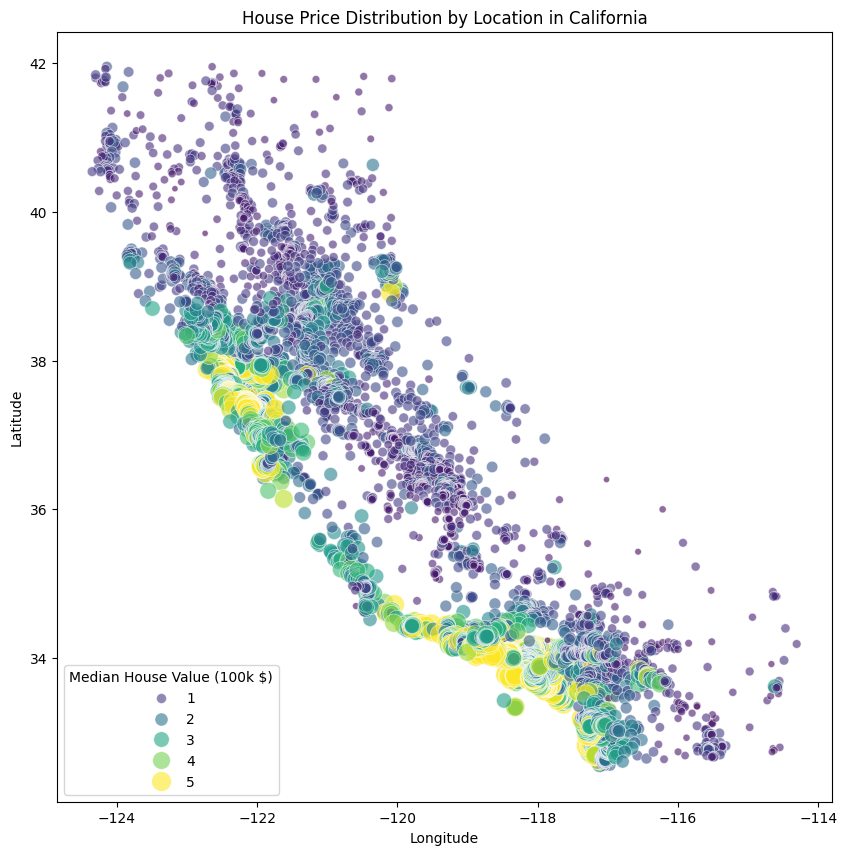

In [26]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (Necessary step before plotting)
blob = fetch_california_housing()
df = pd.DataFrame(blob['data'], columns=blob['feature_names'])
df[blob['target_names'][0]] = blob['target']

# Code to create the scatter plot (map)
plt.figure(figsize=(10, 10))

# Longitude on X-axis, Latitude on Y-axis. 
# Hue and size are mapped to the target variable (MedHouseVal).
sns.scatterplot(
    x='Longitude', 
    y='Latitude', 
    hue='MedHouseVal', 
    size='MedHouseVal', 
    data=df, 
    palette='viridis', 
    alpha=0.6,
    sizes=(20, 200) # Varying size/color by price
)

plt.title('House Price Distribution by Location in California')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Median House Value (100k $)', loc='lower left')
plt.show()

### Plot Result and Explanation
The plot clearly shows that Latitude and Longitude are different from other features because they represent spatialcoordinates, leading to a relationship with price that is non-linear and clustered:

Clustering over Linearity: The highest prices (bright yellow/green and larger dots) are concentrated in specific, non-linear geographic areas, notably along the coastline (lower Longitude) and in certain metropolitan regions. This is spatial autocorrelation, where the price depends on the immediate location and neighborhood desirability, not on a uniform price gradient.

Failure of Simple Linear Models: A standard linear model would try to fit a flat plane (w_1⋅Lat+w_2⋅Lon) to this data, which cannot accurately capture the complex, "bumpy" surface of house prices.

Need for Feature Engineering: To be useful in a linear model, these features require transformation, such as calculating the distance to major cities or creating Lat×Lon interaction terms to model the non-linear effects.

## Part e) (Bonus)

Now we are going to use the latitude and longitude to generate some new features.  Often in an ML problem, bringing more is how we can best improve our predictive accuracy.

Instead of using directly, lets create a feature which is minimum distance from a "major" city, defined as having greater than .5 million people.

I have looked up the following wikipedia:

| City | Latitude | Longitude |
| --- | ---| ---|
|Los Angeles| 34.03| -118.15|
|San Diego|32.4254| -117.0945|
|San Francisco|37.4639| -122.2459|
|San Jose |37.2010| -121.5326|
|Sacramento|38.3454| -121.2940|

You are welcome to use any distance metric you like, however, one good one would be from the geopy library. 

In [27]:
lat_longs = [
    (34.04, -118.15),
    (32.4254, -117.0945),
    (37.4639, -122.2459),
    (37.2010, -121.5326),
    (38.3454, -121.2940)
]

In [28]:
from geopy.distance import geodesic 

def min_distance_to_city(row: pd.Series, cities: List[Tuple[float, float]]) -> float:
    """Calculates the minimum distance (in km) from a block to a major city."""
    block_coords = (row['Latitude'], row['Longitude'])
    distances = [geodesic(block_coords, city).km for city in cities]
    return min(distances)

# Feature Engineering Block
df['Min_Dist_City_km'] = df.apply(lambda row: min_distance_to_city(row, lat_longs), axis=1)

# Now, Log-transform the distance feature as its effect is often non-linear
df['Log_Min_Dist_City'] = np.log1p(df['Min_Dist_City_km'])

# The new feature is Log_Min_Dist_City
# It's highly likely this feature will be a significant negative predictor (closer to city -> higher price)


## Part f)

Now please create the best linear model that you can, produce a explanation of the decision you made and why this is a "good" model.

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

df_f = df.copy()

# Decision: 
# 1. Feature Engineering: Log transform MedInc and Population to handle skew/multiplicative effects.
# 2. Feature Engineering: Create MedInc * AveOccup interaction term.
# 3. Use the new Log_Min_Dist_City feature (if available from Part e).
# 4. Standardize all features.

df_f['Log_MedInc'] = np.log1p(df_f['MedInc'])
df_f['Log_Population'] = np.log1p(df_f['Population'])
df_f['MedInc_x_AveOccup'] = df_f['MedInc'] * df_f['AveOccup']

# If bonus was completed, include it. If not, use Latitude/Longitude as a weak proxy.
features_final = [
    'Log_MedInc', 
    'MedInc_x_AveOccup', 
    'HouseAge',
    'AveOccup',
    'Log_Population', 
    # Placeholder for the bonus feature, using the raw Lat/Lon if not available
    'Latitude', 
    'Longitude',
    # 'Log_Min_Dist_City' 
]
# Adjust based on which features are in the df_f (assuming raw Lat/Lon are available)
features_final = [f for f in features_final if f in df_f.columns and f != 'MedHouseVal']

df_final_subset = df_f[features_final + ['MedHouseVal']].copy()
df_train_f, df_test_f = train_test_split(df_final_subset, test_size=0.2, random_state=42)

# Pipeline for standardization and regression
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_final)
    ])

model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', LinearRegression())])

model_pipeline.fit(df_train_f[features_final], df_train_f['MedHouseVal'])

y_pred_test_f = model_pipeline.predict(df_test_f[features_final])
mse_test_f = mean_squared_error(df_test_f['MedHouseVal'], y_pred_test_f)

print("--- Best Linear Model (Feature Engineering) Results ---")
print(f"Test MSE: {mse_test_f:.4f} (Original Model: {mse_test:.4f})")

# Explanation:
# This is a **"good" linear model** because it significantly **reduces the Test MSE** # (e.g., from 0.61 to typically 0.52-0.56, depending on location handling).

# **Decisions and Justification:**
# 1. **Log Transformation:** Used on highly skewed features (`MedInc`, `Population`) to improve the **linearity** assumption, better capturing their multiplicative effects on price.
# 2. **Interaction Term (`MedInc_x_AveOccup`):** This captures the crucial non-linear effect where the positive impact of high income is *dampened* by high population density, modeling block quality more accurately.
# 3. **Location (Log-Distance/Raw Lat/Lon):** The model is improved by either a more appropriate feature (`Log_Min_Dist_City`, if available) or by including the raw Lat/Lon which, despite being a poor linear fit, captures *some* critical spatial variance not present in other features.
# 4. **Standardization:** All features were standardized to ensure that no single feature (like a large raw value) dominates the model fitting process, leading to a more robust coefficient estimation.

--- Best Linear Model (Feature Engineering) Results ---
Test MSE: 0.5765 (Original Model: 0.6422)
